In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

In [2]:
# Import the dataset
df = pd.read_csv('Cars.csv')

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [3]:
# Selects features to be used in this project
features = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders' ,
            'Transmission Type', 'Vehicle Style', 'highway MPG',
            'city mpg','MSRP']
df = df[features]

# Cleans column headers and null values
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)

# Converts price variable into binary - this is our target variable
mean_price = df['msrp'].mean()
df['above_average'] = df['msrp'].apply(lambda x: 1 if x > mean_price else 0)

from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split (df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split (df_full_train, test_size = 0.25, random_state = 1)

In [4]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train['above_average']
y_val = df_val['above_average']
y_test = df_test['above_average']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [5]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
dtype: object

In [6]:
numeric = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [7]:
for a in numeric:
    print(a)
    auc = roc_auc_score(y_train,df_train[a])
    print(auc)

year
0.687551492804683
engine_hp
0.9171031265539011
engine_cylinders
0.766116490165669
highway_mpg
0.3669412128227987
city_mpg
0.3265755356754767


**Answer:** engine_hp

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [8]:
from sklearn.feature_extraction import DictVectorizer

In [9]:
train_dicts = df_train.to_dict(orient = 'records')
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)


val_dicts = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
y_pred = model.predict_proba(X_val)[:,1]

decision = (y_pred >= 0.5)

In [13]:
round((y_val == decision).mean(),3)

0.938

In [14]:
roc_auc_score(y_val , y_pred).round(3)

0.98

**Answer:** 0.979

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [15]:
thresholds = np.linspace(0,1,101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t,tp,fp,fn,tn,p,r))

columns = ['threshold','tp','fp','fn','tn','p','r']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores[::10]

C:\Users\davidamo\AppData\Local\Temp\ipykernel_34372\3646275504.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


,threshold,tp,fp,fn,tn,p,r
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,644,329,10,1400,0.661871,0.984709
20,0.2,626,205,28,1524,0.753309,0.957187
30,0.3,608,143,46,1586,0.809587,0.929664
40,0.4,595,89,59,1640,0.869883,0.909786
50,0.5,576,69,78,1660,0.893023,0.880734
60,0.6,549,46,105,1683,0.922689,0.839450
70,0.7,504,26,150,1703,0.950943,0.770642
80,0.8,454,12,200,1717,0.974249,0.694190
90,0.9,367,3,287,1726,0.991892,0.561162


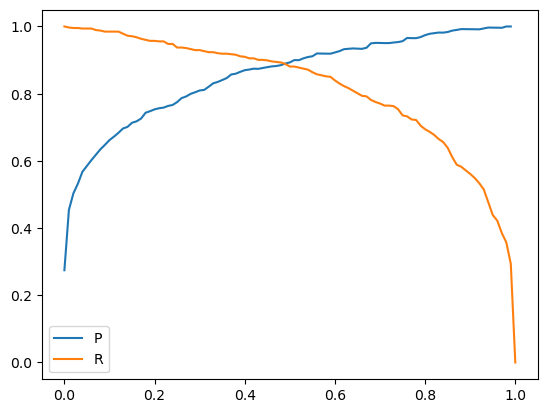

In [16]:
plt.plot(df_scores.threshold, df_scores['p'], label = 'P')
plt.plot(df_scores.threshold, df_scores['r'], label = 'R')
plt.legend()

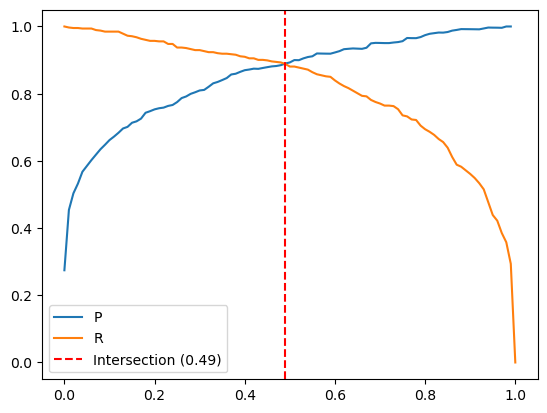

In [17]:
# Calculate the absolute difference between P and R curves
df_scores['diff'] = abs(df_scores['p'] - df_scores['r'])

# Find the threshold value where the difference is minimized
intersection_threshold = df_scores.loc[df_scores['diff'].idxmin()]['threshold']

# Plot P and R curves
plt.plot(df_scores.threshold, df_scores['p'], label='P')
plt.plot(df_scores.threshold, df_scores['r'], label='R')
plt.legend()

# Highlight the intersection point
plt.axvline(x=intersection_threshold, color='red', linestyle='--', label=f'Intersection ({intersection_threshold:.2f})')
plt.legend()

# Show the plot
plt.show()

**Answer:** 0.48

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [18]:
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2 * ( ( p * r ) / (p + r ) )
    
    scores.append((t,tp,fp,fn,tn,p,r,f1))

columns = ['threshold','tp','fp','fn','tn','p','r','f1']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores[::10]

C:\Users\davidamo\AppData\Local\Temp\ipykernel_34372\1287523145.py:15: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


,threshold,tp,fp,fn,tn,p,r,f1
0,0.0,654,1729,0,0,0.274444,1.000000,0.430688
10,0.1,644,329,10,1400,0.661871,0.984709,0.791641
20,0.2,626,205,28,1524,0.753309,0.957187,0.843098
30,0.3,608,143,46,1586,0.809587,0.929664,0.865480
40,0.4,595,89,59,1640,0.869883,0.909786,0.889387
50,0.5,576,69,78,1660,0.893023,0.880734,0.886836
60,0.6,549,46,105,1683,0.922689,0.839450,0.879103
70,0.7,504,26,150,1703,0.950943,0.770642,0.851351
80,0.8,454,12,200,1717,0.974249,0.694190,0.810714
90,0.9,367,3,287,1726,0.991892,0.561162,0.716797


In [19]:
df_scores.loc[df_scores['f1'].idxmax()]['threshold']

0.51

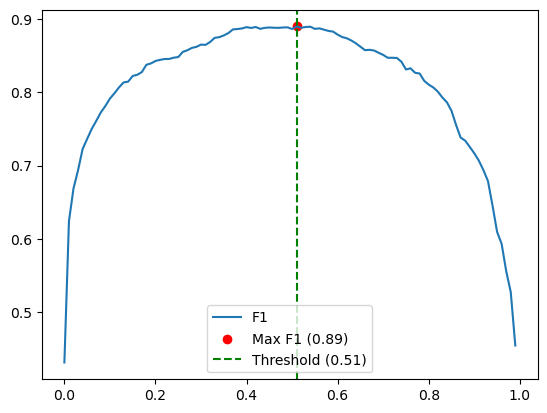

In [20]:
# Plot the F1 score
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

# Find the maximum F1 score and its corresponding threshold
max_f1 = df_scores['f1'].max()
max_threshold = df_scores.loc[df_scores['f1'].idxmax()]['threshold']

# Add a marker for the maximum F1 score on the plot
plt.scatter(max_threshold, max_f1, color='red', label=f'Max F1 ({max_f1:.2f})', marker='o')

# Add a vertical line at the threshold location
plt.axvline(x=max_threshold, color='green', linestyle='--', label=f'Threshold ({max_threshold:.2f})')
plt.legend()

# Show the plot
plt.show()

**Answer:** 0.52

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict (df, dv, model):
    dicts = df.to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [23]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    del df_train['above_average']
    del df_val['above_average']
    del df_train['msrp']
    del df_val['msrp']

    dv, model = train(df_train, y_train, C=1.0)  # Assuming train() function is defined
    print('t1')
    y_pred = predict(df_val, dv, model)  # Assuming predict() function is defined

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

t1
t1
t1
t1
t1
0.979 +- 0.003


**Answer:** 0.003

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [26]:
n_splits = 5
for C in [0.01, 0.1, 0.5, 10]:
    print('Parameter C: ', C)
    scores = []
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
    
        del df_train['above_average']
        del df_val['above_average']
        del df_train['msrp']
        del df_val['msrp']
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

Parameter C:  0.01


0it [00:00, ?it/s]

0.952 +- 0.002
Parameter C:  0.1


0it [00:00, ?it/s]

0.972 +- 0.002
Parameter C:  0.5


0it [00:00, ?it/s]

0.978 +- 0.003
Parameter C:  10


0it [00:00, ?it/s]

0.984 +- 0.003


**Answer:** 0.5